In [57]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from tifffile import TiffFile

from atlas import loadmat, NPAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

## Figure 1: NWB extension for optophysiology in C. elegans

This will probably be an illustrator created visual which shows all of the different objects that go into the NWB file and how they interplay with each other. Similar to how it is shown in the NWB tutorails

## Figure 2: Software pipelines for working with NWB

## Table 1: Summary of collected datasetes

Columns will be: source paper, lab, number of worms, NP/GCaMP/both, average num segmented neurons, average num ID labels, notes

## Figure 3: Summary statistics of datasets

Unprocessed data from each dataset run through NP software, box-whisker plot, plus additional box for performance of consolidated dataset

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:53

   seg   ID  labels
0  183  183  Yemini
1  166  164  Yemini
2  178  175  Yemini
3  184  180  Yemini
4  180  175  Yemini


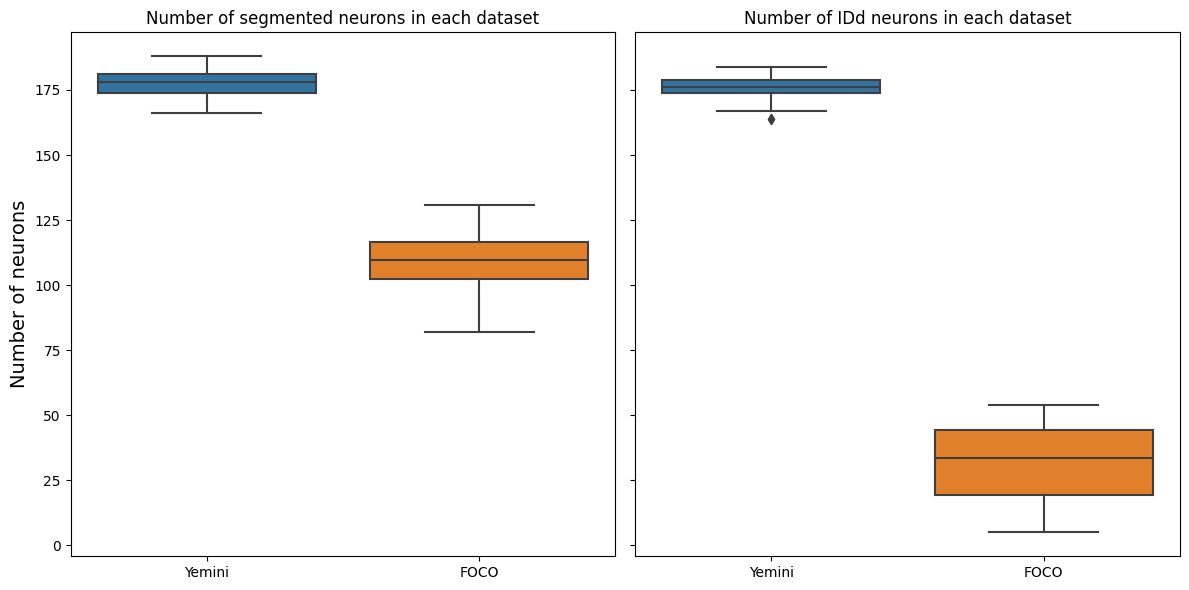

In [2]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

Yem_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/Yemini_NWB')
FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray')

num_seg_yem, num_ID_yem = get_summary_stats(Yem_dataset)
num_seg_FOCO, num_ID_FOCO = get_summary_stats(FOCO_dataset)

plot_summary_stats([num_seg_yem, num_seg_FOCO], [num_ID_yem, num_ID_FOCO], ['Yemini', 'FOCO'])

In [3]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([Yem_dataset, FOCO_dataset])
print(tot_dataset.keys())

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04'])


In [43]:
pair_yem = get_pairings(Yem_dataset)

In [ ]:
pair_FOCO = get_pairings(FOCO_dataset)

In [44]:
pair_tot = get_pairings(tot_dataset)

In [45]:
atlas = NPAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/atlas_xx_rgb.mat', ganglia ='/Users/danielysprague/foco_lab/data/atlases/neuron_ganglia.csv' )
atlas.create_dictionary()
df = atlas.get_df()

In [46]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='whitegrid')

    plt.figure(figsize=(12,8))
    sns.barplot(x='ID', y='frac', hue='ganglion', data=merged)

    plt.xlabel('Neuron IDs')
    plt.ylabel('Fraction of datasets with ground truth labeled neuron')

    plt.xticks(rotation=60, ha='right', fontsize=6)

    bar_width = 0.7

    for patch in plt.gca().patches:
        current_width = patch.get_width()
        diff = current_width - bar_width

        # Change the bar width
        patch.set_width(bar_width)

        # Recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

    # Show the plot
    plt.legend(title='ganglion', loc='upper right')

    plt.show()




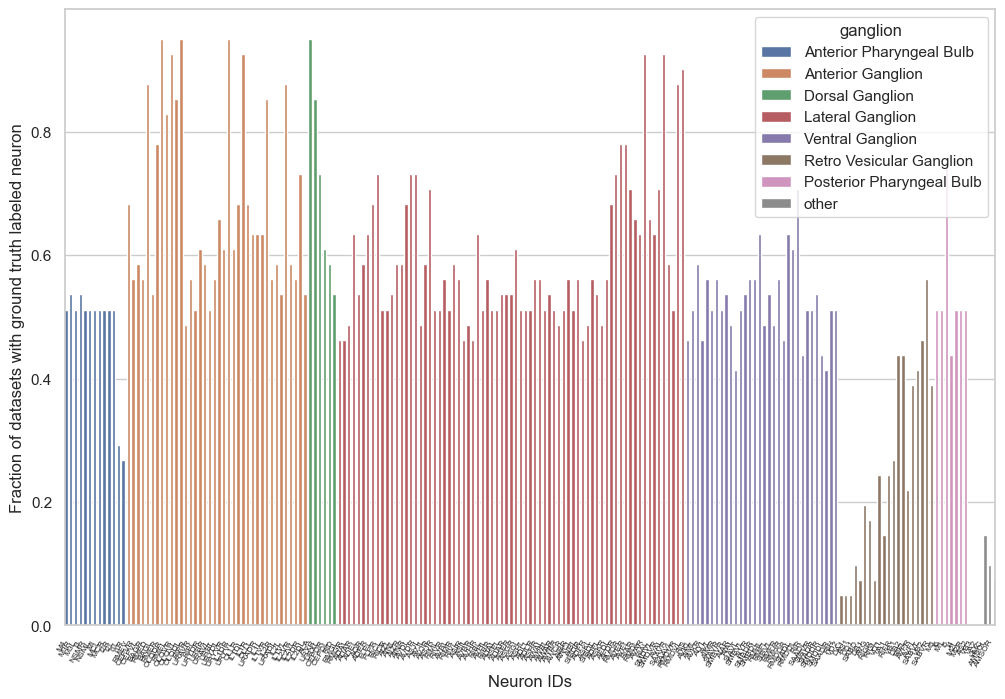

In [47]:
neurons, num = get_neur_nums(tot_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

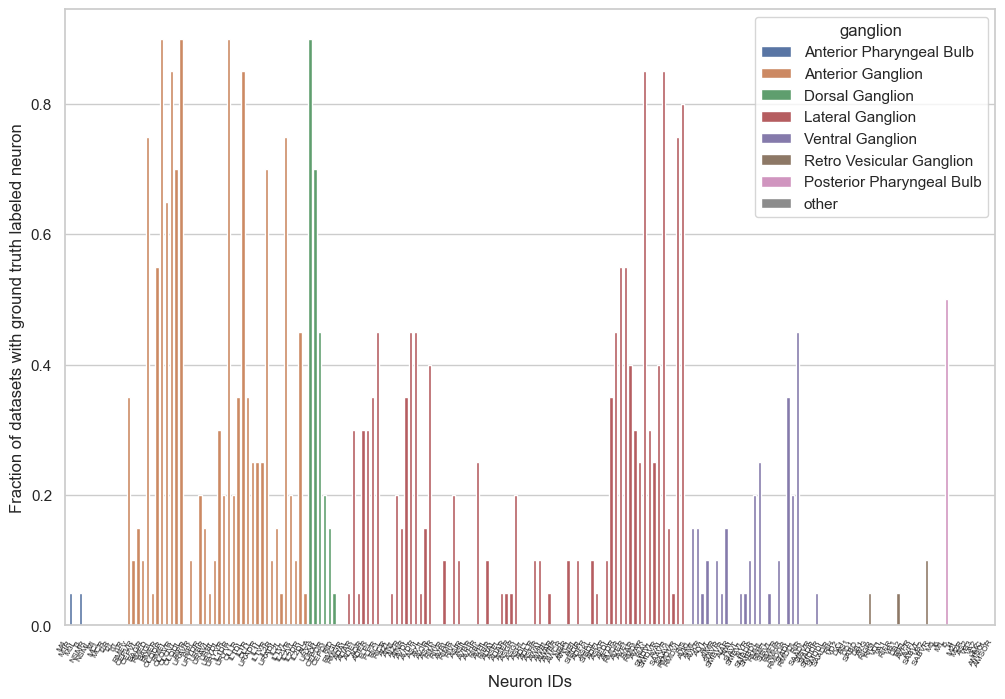

In [48]:
neurons, num = get_neur_nums(FOCO_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

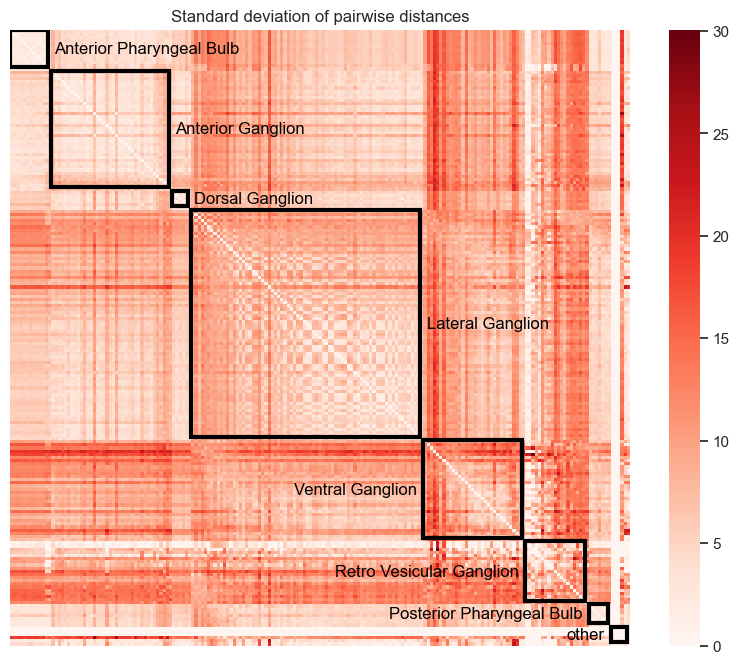

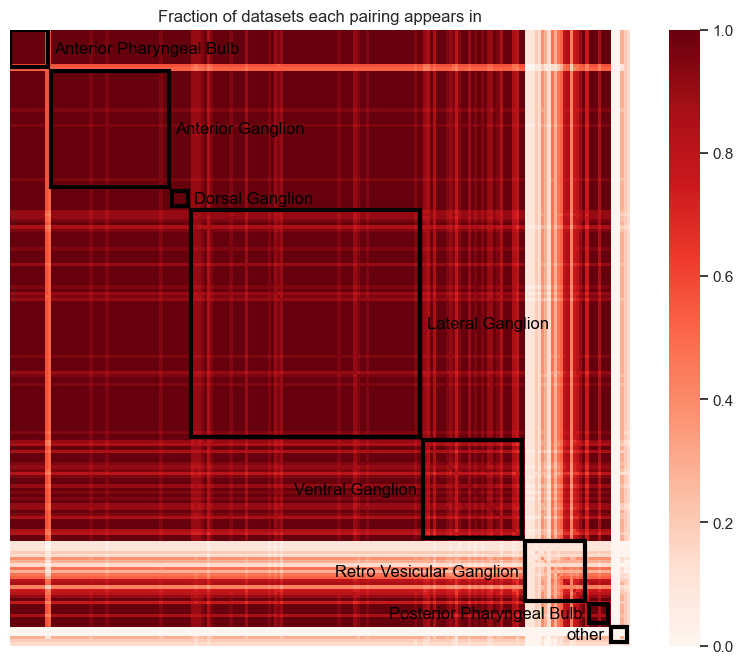

In [49]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_yem, df, 21)
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

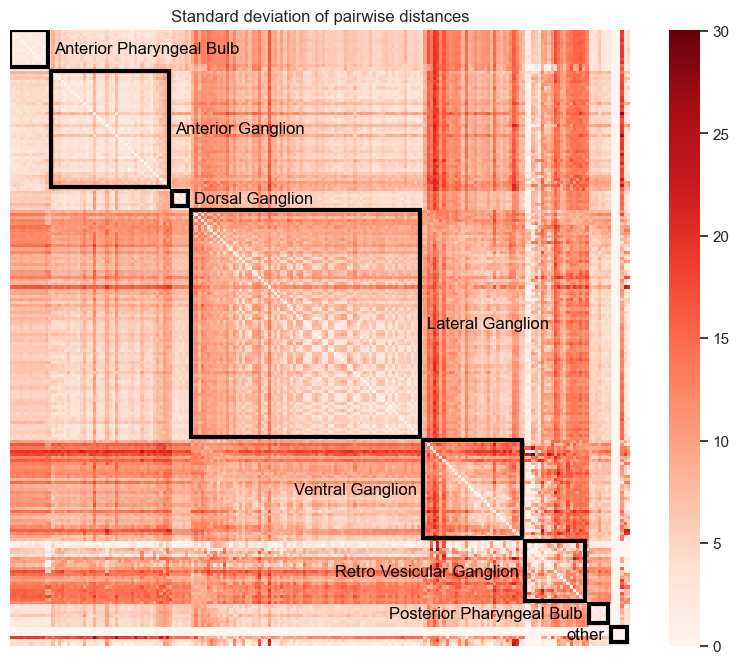

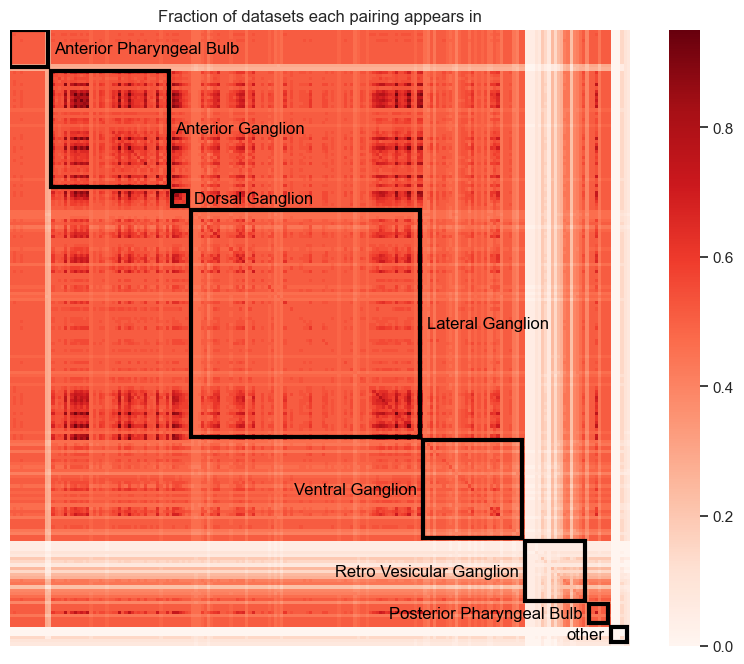

In [50]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_tot, df, len(Yem_dataset.keys())+len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

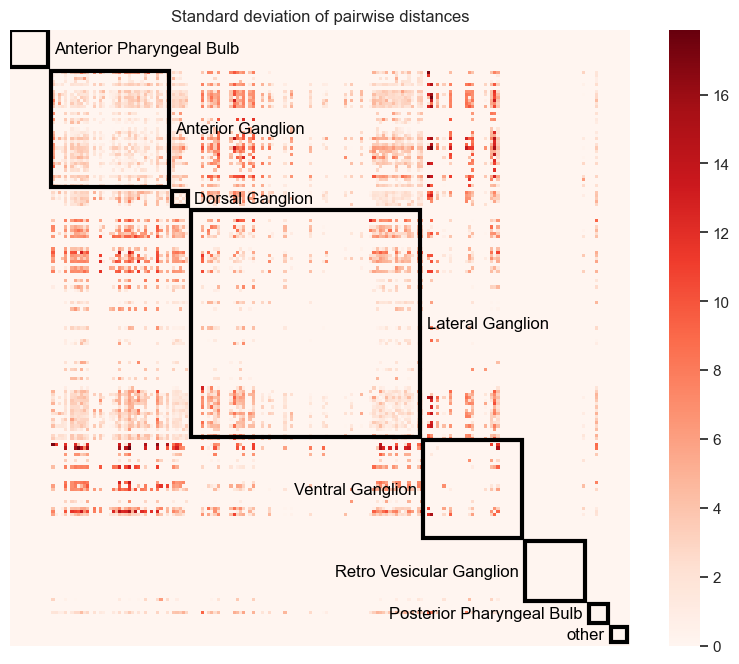

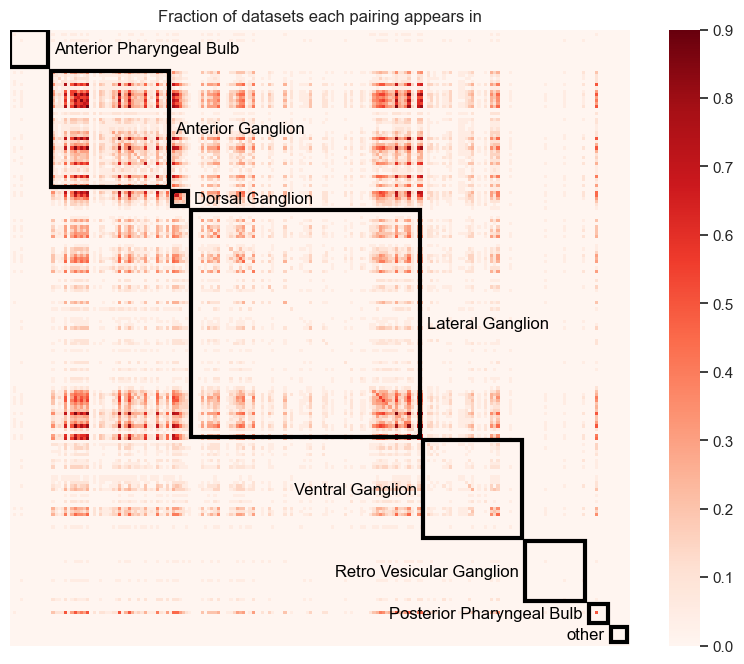

In [51]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_FOCO, df, len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

In [ ]:
print(FOCO_dataset.keys())
blobs = FOCO_dataset['20230412-20-15-17']
IDd = blobs[blobs['ID']!='']
print(np.asarray(IDd['ID']))

dict_keys(['20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04'])
['URADL' 'URYVL' 'OLQVL' 'URYDL' 'OLQDL' 'RMEL' 'RMED' 'RMDVR' 'URXL'
 'ALA']


In [ ]:
print(pair_FOCO.keys())

dict_keys(['-', '-IL1DR', 'IL1DR-', '-IL1DL', 'IL1DL-', '-IL2R', 'IL2R-', '-URADR', 'URADR-', '-IL1VL', 'IL1VL-', '-IL1R', 'IL1R-', '-OLLL', 'OLLL-', '-OLLR', 'OLLR-', '-URYVR', 'URYVR-', '-URYDR', 'URYDR-', '-URAVR', 'URAVR-', '-OLQVL', 'OLQVL-', '-URYDL', 'URYDL-', '-OLQVR', 'OLQVR-', '-OLQDR', 'OLQDR-', '-OLQDL', 'OLQDL-', '-RMER', 'RMER-', '-RMEL', 'RMEL-', '-RMED', 'RMED-', '-RMDVL', 'RMDVL-', '-RMDVR', 'RMDVR-', '-RMEV', 'RMEV-', '-RIAL', 'RIAL-', '-URXR', 'URXR-', '-AVAR', 'AVAR-', '-AVAL', 'AVAL-', '-ALA', 'ALA-', '-CEPDR', 'CEPDR-', '-RMDR', 'RMDR-', '-URXL', 'URXL-', '-RMDDL', 'RMDDL-', 'IL1DR-IL1DR', 'IL1DR-IL1DL', 'IL1DL-IL1DR', 'IL1DR-IL2R', 'IL2R-IL1DR', 'IL1DR-URADR', 'URADR-IL1DR', 'IL1DR-IL1VL', 'IL1VL-IL1DR', 'IL1DR-IL1R', 'IL1R-IL1DR', 'IL1DR-OLLL', 'OLLL-IL1DR', 'IL1DR-OLLR', 'OLLR-IL1DR', 'IL1DR-URYVR', 'URYVR-IL1DR', 'IL1DR-URYDR', 'URYDR-IL1DR', 'IL1DR-URAVR', 'URAVR-IL1DR', 'IL1DR-OLQVL', 'OLQVL-IL1DR', 'IL1DR-URYDL', 'URYDL-IL1DR', 'IL1DR-OLQVR', 'OLQVR-IL1DR',

### Color statistics of datasets

In [52]:
def get_color_stats(folder):

    rgbhist = np.zeros((32,3))

    neur_colors = {}

    for file in os.listdir(folder):
        if not file[-4:] == '.nwb':
            continue

        print(file)

        blobs, rgb_data = get_nwb_neurons(folder+'/'+file)

        color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))

        blobs[['Rnorm', 'Gnorm','Bnorm']] = np.nan

        for i, row in blobs.iterrows():
            colors = color_norm[max(row['x']-2,0):min(row['x']+2,rgb_data.shape[0]-1),max(row['y']-2,0):min(row['y']+2,rgb_data.shape[1]-1),max(row['z']-1,0):min(row['z']+1,rgb_data.shape[2]-1),:]

            flat_colors = colors.reshape(-1, colors.shape[-1])
            
            Rnorm = np.median(flat_colors[0])
            Gnorm = np.median(flat_colors[1])
            Bnorm = np.median(flat_colors[2])

            blobs.loc[i, 'Rnorm'] = Rnorm
            blobs.loc[i, 'Gnorm'] = Gnorm
            blobs.loc[i, 'Bnorm'] = Bnorm

        IDd = blobs[blobs['ID']!='']

        for i, row in IDd.iterrows():
            ID = row['ID']
            colors = np.asarray(row[['Rnorm', 'Gnorm', 'Bnorm']])
            if not ID in neur_colors:
                neur_colors[ID] = [colors]
            else:
                neur_colors[ID].append(colors)
            
        image = np.asarray(color_norm)
        im_flat = image.reshape(-1, image.shape[-1])

        rhist, bins = np.histogram(im_flat[:,0], bins=32, range=(0,1))
        ghist, bins = np.histogram(im_flat[:,1], bins=32, range=(0,1))
        bhist, bins = np.histogram(im_flat[:,2], bins=32, range=(0,1))

        rgbhist[:,0] += rhist
        rgbhist[:,1] += ghist
        rgbhist[:,2] += bhist
    
    rgbhist[:,0] = rgbhist[:,0]/np.sum(rgbhist[:,0])
    rgbhist[:,1] = rgbhist[:,1]/np.sum(rgbhist[:,1])
    rgbhist[:,2] = rgbhist[:,2]/np.sum(rgbhist[:,2])

    return rgbhist, neur_colors

In [53]:
foco_rgb, foco_colors = get_color_stats('/Users/danielysprague/foco_lab/data/NWB_Ray')
yem_rgb, yem_colors = get_color_stats('/Users/danielysprague/foco_lab/data/Yemini_NWB')


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


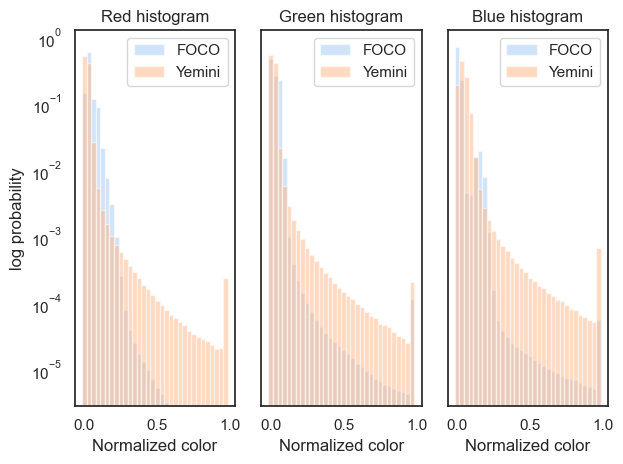

In [54]:
def plot_histograms(dataset_rgbs, labels):

    sns.set(style="white")
    fig, axs = plt.subplots(1,3, sharey=True)

    # Plot the bars using Matplotlib

    bin_edges = np.arange(32)/32

    for i, ax in enumerate(axs):
        #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
        for j, dataset in enumerate(dataset_rgbs):
            ax.bar(bin_edges[:], dataset[:,i], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[j], log=True, label=labels[j])
            #ax.bar(bin_edges[:], yem_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[1], log=True, label='Yemini')
        ax.legend()
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(foco_rgb[:,i]), bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='FOCO')
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(yem_rgb[:,i]), bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='Yemini')

    axs[0].set_title('Red histogram')
    axs[0].set_xlabel('Normalized color')
    axs[0].set_ylabel('log probability')
    axs[1].set_title('Green histogram')
    axs[1].set_xlabel('Normalized color')
    axs[2].set_title('Blue histogram')
    axs[2].set_xlabel('Normalized color')

    plt.tight_layout()
    plt.show()

plot_histograms([foco_rgb, yem_rgb], ['FOCO', 'Yemini'])

In [77]:
color_discrim_FOCO = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_Ray', 6)
color_discrim_Yemini = get_color_discrim('/Users/danielysprague/foco_lab/data/Yemini_NWB', 6)


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


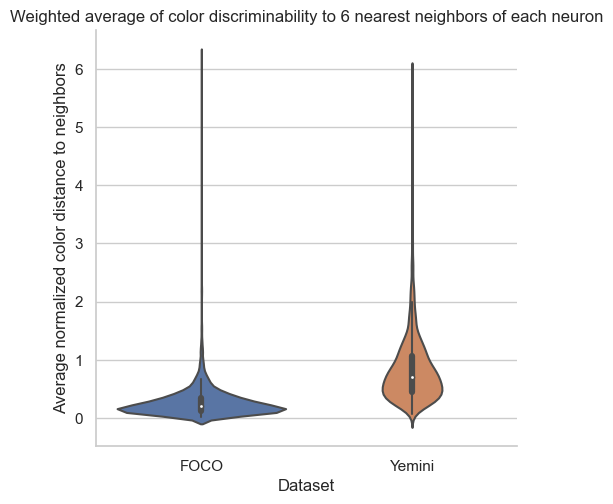

In [102]:
plot_color_discrim([color_discrim_FOCO, color_discrim_Yemini], ['FOCO', 'Yemini'])

## Figure 4: Benchmarking performance of consolidated datasets 

All experiments run using consolidated dataset, different image processing approaches, box-whisker plot similar to above

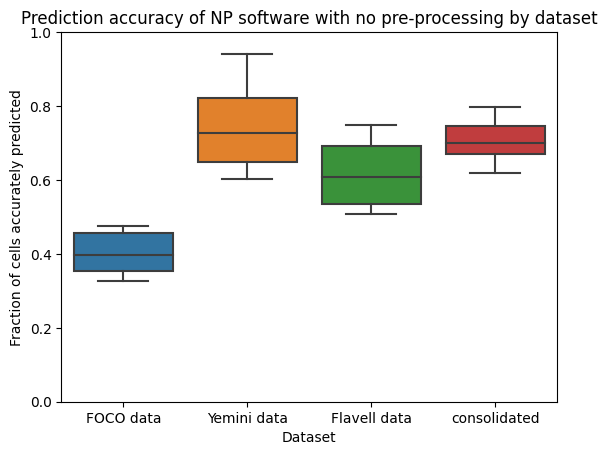

In [10]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['FOCO data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Yemini data']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Flavell data']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['consolidated']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software with no pre-processing by dataset')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Dataset')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

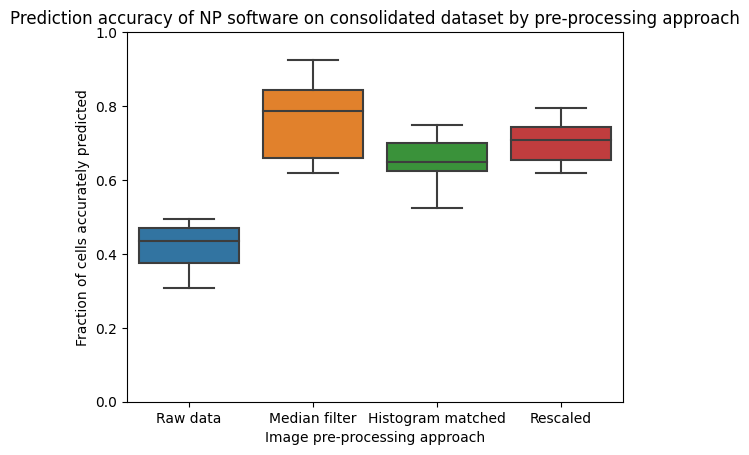

In [12]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['Raw data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Median filter']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Histogram matched']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['Rescaled']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software on consolidated dataset by pre-processing approach')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Image pre-processing approach')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

## Figure 5: Atlas visualizations - projected color space visualization, unrollled butterfly visualization